# NEKA - 2023-2024
The objective is to say if a driver is tired or not, to avoid car accidents. The idea of this file is to preprocess face images to generate a model which is able to predict drowsiness.

## 1 Imports

In [53]:
from matplotlib import pyplot as plt
import os
import numpy as np
import cv2
import tensorflow as tf
# --- keras ---
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import Precision, Recall, AUC
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from scikeras.wrappers import KerasClassifier
# --- sklearn ---
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score

## 2 Global Constant Variables
These constants will be used during the whole dataset, making the development cleaner and easier.

In [56]:
RANDOM_SEED = 42
CLASS_NAMES = ('Awake', 'Tired')
EPOCHS = 10
BATCH_SIZE = 32

## 3 Global Utils
These functions will be used during the whole dataset, making the development cleaner and easier.

### 3.1 Save Data

In [4]:
# Function to create class folders within the specified directory
def create_class_folders(output_dir, classes):
    for class_name in classes:
        class_path = os.path.join(output_dir, class_name)
        os.makedirs(class_path, exist_ok=True)

# Function to save images from a dataset to class-specific folders
def save_images(X, y, output_dir, classes):
    create_class_folders(output_dir, classes)

    # Save the images to the specified folder
    for i, (img, label) in enumerate(zip(X, y)):
        class_path = os.path.join(output_dir, label)
        filename = f'image_{len(os.listdir(class_path)) + 1}.png'
        filepath = os.path.join(class_path, filename)
        
        # Save the image
        cv2.imwrite(filepath, img)

### 3.2 Plot Images

In [39]:
def plot_line_of_images(X, y, n_images):
    fig, ax = plt.subplots(ncols=n_images, figsize=(20, 20))
    for idx, img in enumerate(X[:n_images]):
        ax[idx].imshow(img.astype(int))
        ax[idx].title.set_text(f"Label: {y[idx]}")
        
def plot_desired_images(X, y, indexes):
    fig, ax = plt.subplots(ncols=len(indexes), figsize=(20, 20))
    for idx, img in enumerate(X[indexes]):
        ax[idx].imshow(img.astype(int))
        ax[idx].title.set_text(f"Label: {y[indexes[idx]]}")    

## 4 Load Data
The data that will be used to create CNN capable to detect drowsiness levels will be uploaded during the following cells.

### 4.1 Load Data Constant Variables

In [6]:
DIR_RAW_DATA_TIRED = '../data/raw/FinalDataset/Tired'
DIR_RAW_DATA_AWAKE = '../data/raw/FinalDataset/Awake'

RAW_IMAGE_SIZE = (256, 256)

### 4.2 Load Data Utils

In [7]:
def load_images_from_folder(folder, resize):
    images = []
    labels = []
    
    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)
        label = folder.split("/")[-1]  # Extract class label from folder name
        
        if os.path.isfile(path):
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, resize)
            
            images.append(img)
            labels.append(label)
    
    return np.array(images), np.array(labels)

### 4.3 Finally Load Data
The data that will be used to create CNN capable to detect drowsiness levels will be uploaded during the following cells.

In [8]:
X_tired_raw, y_tired_raw = load_images_from_folder(DIR_RAW_DATA_TIRED, RAW_IMAGE_SIZE)
X_awake_raw, y_awake_raw = load_images_from_folder(DIR_RAW_DATA_AWAKE, RAW_IMAGE_SIZE)

X_raw = np.concatenate([X_awake_raw, X_tired_raw], axis=0)
y_raw = np.concatenate([y_awake_raw, y_tired_raw], axis=0)

X_shuffled, y_shuffled = shuffle(X_raw, y_raw, random_state=RANDOM_SEED)

print(f"Loaded images: {X_shuffled.shape}")
print(f"Loaded labels: {y_shuffled.shape}")

Loaded images: (2040, 256, 256, 3)
Loaded labels: (2040,)


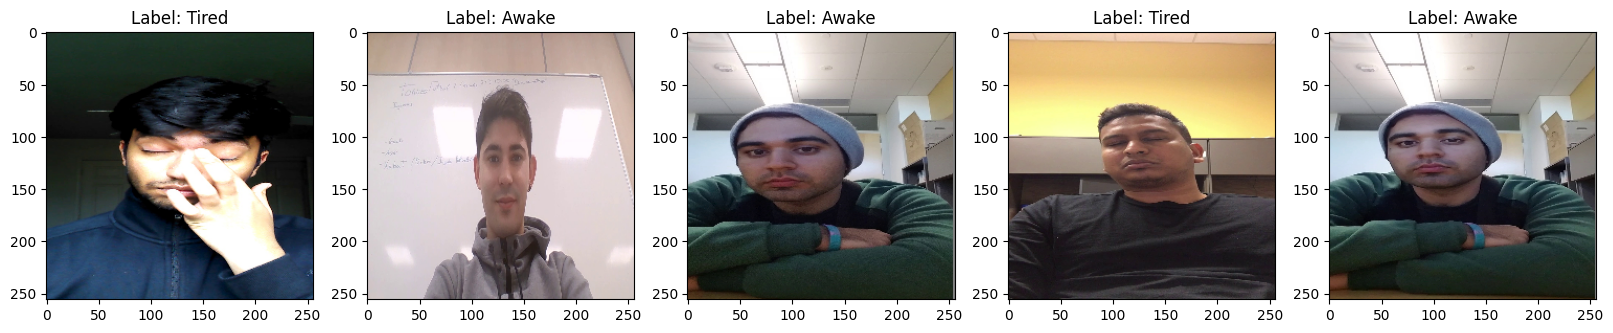

In [9]:
plot_line_of_images(X_shuffled, y_shuffled, 5)

## 5 Train Test Split
In order to check whether the modelling succeeded (if overfitting didn't occur) a train test split will be made at the beginnig of the process. This way the validation set generated below will be used to simulate unseen data.

### 5.1 Train Test Split Constants

In [10]:
DIR_TRAIN_DATA = '../data/raw/FinalDatasetTrainTest/train'
DIR_TEST_DATA = '../data/raw/FinalDatasetTrainTest/test'

### 5.2 Make Train Test Splits

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.2, random_state=RANDOM_SEED)

In [12]:
# save split
save_images(X_train, y_train, DIR_TRAIN_DATA, CLASS_NAMES)
save_images(X_test, y_test, DIR_TEST_DATA, CLASS_NAMES)

## 6 Preprocessing

### 6.1 Haar Cascade Cropping

During this notebook Haar Cascade algorithm will be implemented to crop and preprocess the images that will be used for further model training.

#### 6.1.1 Haar Cascade Constant Variables

In [13]:
DIR_TRAIN_DATA_CROPPED = '../data/interim/FinalDatasetCropped/'

CROPPED_IMAGE_SIZE = (128, 128)
HAAR_CASCADE_MODEL_PATH = '../models/haarcascade_frontalface_alt2.xml'

#### 6.1.2 Haar Cascade Utils

In [14]:
def load_face_cascade(path):
    face_cascade = cv2.CascadeClassifier(path)
    if face_cascade.empty():
        print("Error loading Haar Cascade classifier.")
    else:
        print("Haar Cascade classifier loaded successfully.")
    return face_cascade

def apply_haar_cascade_on_image(image, face_cascade):
    miscropped = False
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY).astype(np.uint8)

    # apply algorithm
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4)

    if len(faces) > 0:
        # Draw a rectangle around the main face and crop this
        (x, y, w, h) = faces[0]
        # cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
        detected_face = image[y:y + h, x:x + w]
    else:
        miscropped = True
        detected_face = image

    return detected_face, miscropped

def apply_haar_cascade_on_images(images, face_cascade):
    cropped_images = np.random.random((images.shape[0], CROPPED_IMAGE_SIZE[0], CROPPED_IMAGE_SIZE[1], 3))
    
    miscropped_images = 0

    for idx, image in enumerate(images):
        detected_face, miscropped = apply_haar_cascade_on_image(image, face_cascade)
        
        cropped_images[idx] = np.array(cv2.resize(detected_face.astype(np.uint8), CROPPED_IMAGE_SIZE))
        
        if miscropped: 
            miscropped_images += 1

    return miscropped_images, cropped_images

#### 6.1.3 Apply Haar Cascade Cropping

In [15]:
face_cascade = load_face_cascade(HAAR_CASCADE_MODEL_PATH) 
miscropped_images, X_train_cropped = apply_haar_cascade_on_images(X_train, face_cascade)

print("All Test Cropped Images Shape:", X_train_cropped.shape)
print("All MisCropped Test Images:", miscropped_images)

Haar Cascade classifier loaded successfully.
All Test Cropped Images Shape: (1632, 128, 128, 3)
All MisCropped Test Images: 188


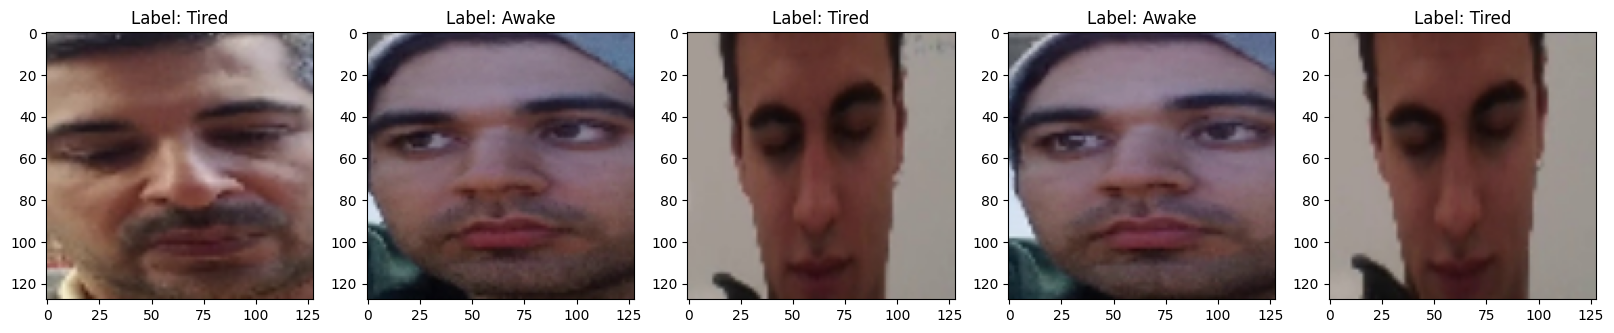

In [16]:
plot_line_of_images(X_train_cropped, y_train, 5)

In [17]:
# save data
save_images(X_train_cropped, y_train, DIR_TRAIN_DATA_CROPPED, CLASS_NAMES)

### 6.2 Data Augmentation

What is Data Augmentation? Data augmentation is a technique of artificially increasing the training set by creating modified copies of a dataset using existing data. It includes making minor changes to the dataset or using deep learning to generate new data points.

#### 6.2.1 Data Augmentation Constant Variables

In [32]:
DIR_TRAIN_DATA_AUGMENTED = '../data/final/FinalDatasetCroppedAugmented/'

#### 6.2.2 Apply Data Augmentation

In [28]:
imgTrainGen = ImageDataGenerator(
    rotation_range = 50,
    width_shift_range = 0.3,
    height_shift_range = 0.3,
    shear_range = 15,
    zoom_range = [0.5, 1.5],
    vertical_flip = True,
    # orizontal_flip = True
)

In [29]:
# Randomly select a subset of images to apply augmentation
num_images = len(X_train_cropped)
num_images_to_augment = np.random.randint(1, num_images/10)  # Augment at least one image

# Randomly choose indices for augmentation
augmented_indices = np.random.choice(num_images, size=num_images_to_augment, replace=False)

In [46]:
X_train_augmented = np.copy(X_train_cropped)

# Apply data augmentation to the selected subset
for idx in augmented_indices:
    X_train_augmented[idx] = imgTrainGen.random_transform(X_train_cropped[idx])
    
# Print augmentation info
print("Amount of augmented images:", num_images_to_augment)

Amount of augmented images: 95


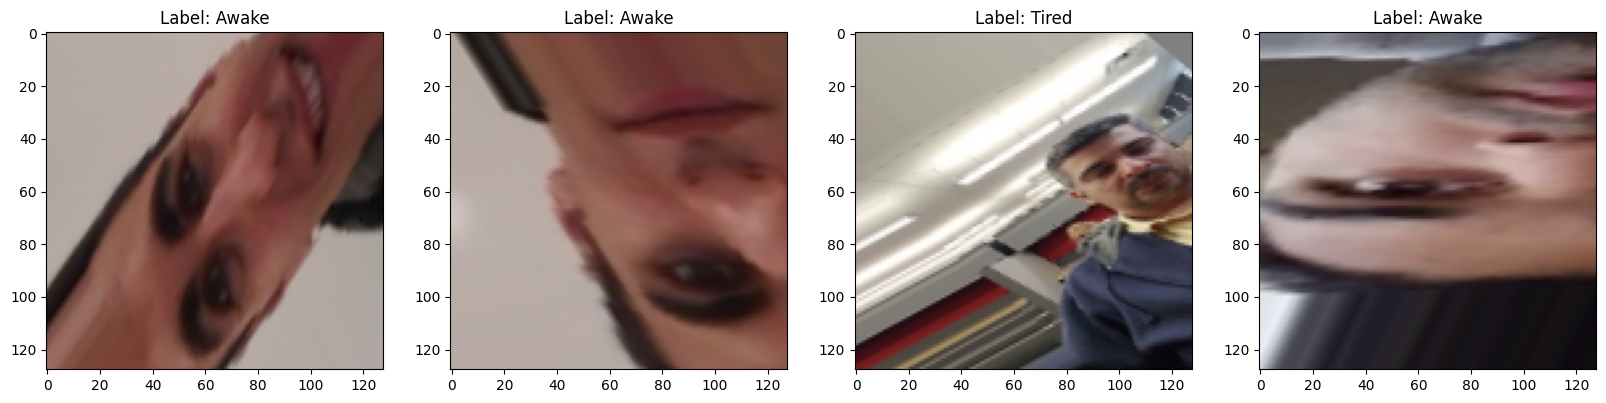

In [47]:
plot_desired_images(X_train_augmented, y_train, augmented_indices[:4])

In [48]:
# save data
save_images(X_train_augmented, y_train, DIR_TRAIN_DATA_AUGMENTED, CLASS_NAMES)

### 6.3 Normalization
In computer vision, the pixel normalization technique is often used to speed up model learning. The normalization of an image consists in dividing each of its pixel values by the maximum value that a pixel can take (255 for an 8-bit image, 4095 for a 12-bit image, 65 535 for a 16-bit image).

In [49]:
X_train_normalized = X_train_augmented/255

## 7 Modelling

### 7.1 Cross Validation

Test the model's ability to predict new data that was not used in estimating it, in order to flag problems like overfitting or selection bias and to give an insight on how the model will generalize to an independent dataset (i.e., an unknown dataset, for instance from a real problem).

#### 7.1.1 Cross Validation Constant Variables

In [24]:
NUM_FOLDS = 3

#### 7.1.2 Cross Validation Utils

In [25]:
# Function to build the model (required for KerasClassifier)
def build_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])

    return model

#### 7.1.3 Apply CV

In [35]:
# Convert the model to a scikit-learn compatible classifier
model = KerasClassifier(build_fn=build_model, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

In [51]:
# CV configuration
cv = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=RANDOM_SEED)

# Define the desired metric
scoring_metric = make_scorer(accuracy_score)

# use cross_validate to validate the model on the whole training set
cv_results = cross_validate(
    model,
    X=X_train_normalized,
    y=y_train,
    cv=cv,
    scoring={'accuracy': scoring_metric},  # Puedes agregar más métricas según tus necesidades
    fit_params={'epochs': EPOCHS},
    return_train_score=False,
    return_estimator=False
)

C:\Users\rubio\anaconda3\envs\neka\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
34/34 [==============================] - 15s 387ms/step - loss: 0.6119 - accuracy: 0.6572 - precision_7: 0.6507 - recall_7: 0.6042 - auc_7: 0.7383
Epoch 2/10
34/34 [==============================] - 12s 353ms/step - loss: 0.2448 - accuracy: 0.9118 - precision_7: 0.9137 - recall_7: 0.8996 - auc_7: 0.9665
Epoch 3/10
34/34 [==============================] - 12s 342ms/step - loss: 0.1279 - accuracy: 0.9577 - precision_7: 0.9574 - recall_7: 0.9537 - auc_7: 0.9881
Epoch 4/10
34/34 [==============================] - 12s 342ms/step - loss: 0.1058 - accuracy: 0.9669 - precision_7: 0.9689 - recall_7: 0.9614 - auc_7: 0.9914
Epoch 5/10
34/34 [==============================] - 12s 351ms/step - loss: 0.0815 - accuracy: 0.9789 - precision_7: 0.9806 - recall_7: 0.9749 - auc_7: 0.9931
Epoch 6/10
34/34 [==============================] - 12s 341ms/step - loss: 0.0636 - accuracy: 0.9816 - precision_7: 0.9844 - recall_7: 0.9768 - auc_7: 0.9966
Epoch 7/10
34/34 [==============================] - 

C:\Users\rubio\anaconda3\envs\neka\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
34/34 [==============================] - 14s 362ms/step - loss: 0.5922 - accuracy: 0.6985 - precision_8: 0.6813 - recall_8: 0.6892 - auc_8: 0.7775
Epoch 2/10
34/34 [==============================] - 13s 376ms/step - loss: 0.2488 - accuracy: 0.9072 - precision_8: 0.9080 - recall_8: 0.8958 - auc_8: 0.9639
Epoch 3/10
34/34 [==============================] - 13s 397ms/step - loss: 0.1528 - accuracy: 0.9642 - precision_8: 0.9579 - recall_8: 0.9672 - auc_8: 0.9840
Epoch 4/10
34/34 [==============================] - 15s 438ms/step - loss: 0.0977 - accuracy: 0.9697 - precision_8: 0.9602 - recall_8: 0.9768 - auc_8: 0.9926
Epoch 5/10
34/34 [==============================] - 14s 410ms/step - loss: 0.0615 - accuracy: 0.9816 - precision_8: 0.9826 - recall_8: 0.9788 - auc_8: 0.9960
Epoch 6/10
34/34 [==============================] - 13s 371ms/step - loss: 0.0472 - accuracy: 0.9825 - precision_8: 0.9864 - recall_8: 0.9768 - auc_8: 0.9977
Epoch 7/10
34/34 [==============================] - 

C:\Users\rubio\anaconda3\envs\neka\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
34/34 [==============================] - 15s 384ms/step - loss: 0.5663 - accuracy: 0.7151 - precision_9: 0.6891 - recall_9: 0.7317 - auc_9: 0.7951
Epoch 2/10
34/34 [==============================] - 13s 396ms/step - loss: 0.1951 - accuracy: 0.9366 - precision_9: 0.9276 - recall_9: 0.9402 - auc_9: 0.9756
Epoch 3/10
34/34 [==============================] - 15s 437ms/step - loss: 0.1050 - accuracy: 0.9715 - precision_9: 0.9710 - recall_9: 0.9691 - auc_9: 0.9916
Epoch 4/10
34/34 [==============================] - 17s 495ms/step - loss: 0.0917 - accuracy: 0.9614 - precision_9: 0.9559 - recall_9: 0.9633 - auc_9: 0.9945
Epoch 5/10
34/34 [==============================] - 16s 467ms/step - loss: 0.0728 - accuracy: 0.9761 - precision_9: 0.9677 - recall_9: 0.9826 - auc_9: 0.9963
Epoch 6/10
34/34 [==============================] - 14s 399ms/step - loss: 0.0663 - accuracy: 0.9761 - precision_9: 0.9786 - recall_9: 0.9710 - auc_9: 0.9962
Epoch 7/10
34/34 [==============================] - 

In [52]:
# Print results
print("Mean Accuracy:", np.mean(cv_results['test_accuracy']))
print("Accuracy std:", np.std(cv_results['test_accuracy']))

Mean Accuracy: 0.9681372549019608
Accuracy std: 0.0031243992117602737


### 7.2 Final CNN Training

#### 7.2.1 Final CNN Training Constant Variables

In [66]:
DIR_DUMP_FINAL_MODEL = '../models/01FinalDatasetModel.h5'
DIR_DUMP_FINAL_MODEL_WEIGHTS = '../models/01FinalDatasetModelWeights.h5'

#### 7.2.2 Apply CNN Training

In [54]:
ModeloFinalCNN2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)), # Adds a convolution layer with 32 filters of size 3x3, activated by the ReLU activation function.
    tf.keras.layers.MaxPooling2D(2, 2), # Adds a Max Pooling layer to reduce the spatial dimensionality of the convolutional layer output.
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(), # This layer flattens the output of the last convolution layer (transforming it into a one-dimensional vector) to prepare it for the densely connected layers.
    tf.keras.layers.Dropout(0.5), # Adds a Dropout layer to help prevent overfitting, randomly deactivating 50% of the neurons during training.
    tf.keras.layers.Dense(256, activation='relu'), # A dense layer with 256 neurons and ReLU activation.
    tf.keras.layers.Dense(1, activation='sigmoid') # Output layer with a single neuron and sigmoid activation, commonly used for binary classification problems.
])

In [55]:
# Define a mapping dictionary
class_mapping = {'Awake': 0, 'Tired': 1}

# Use the mapping function to convert string labels to numerical labels
y_train_numerical = np.array([class_mapping[label] for label in y_train])

# Print the result
print("Original Labels:", y_train)
print("Numerical Labels:", y_train_numerical)

Original Labels: ['Tired' 'Awake' 'Tired' ... 'Tired' 'Tired' 'Tired']
Numerical Labels: [1 0 1 ... 1 1 1]


In [57]:
ModeloFinalCNN2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])

history = ModeloFinalCNN2.fit(X_train_normalized, y_train_numerical, epochs=EPOCHS, batch_size=BATCH_SIZE) 
# During the training process, in each epoch, the imgTrain generator will generate batches of augmented images and their corresponding labels to train your model. This allows the model to be trained on the dynamically augmented images at each epoch, thus improving its ability to generalize from variations of the original images.

# imgTrain: It is the data flow generator you created with data augmentation

# epochs=10: Indicates the number of times the entire training data set will be passed back and forth through the neural network during training.

# batch_size=32: Specifies the number of samples used in each training iteration. The model is updated after each batch. In this case, a lot size of 32 is used.

# validation_data=validation_set: The validation data set is provided here to evaluate the performance of the model on data not used in training. This helps monitor whether the model is overfitting or generalizing well.

Epoch 1/10
51/51 [==============================] - 19s 347ms/step - loss: 0.4446 - accuracy: 0.8002 - precision_10: 0.8485 - recall_10: 0.7066 - auc_10: 0.8699
Epoch 2/10
51/51 [==============================] - 17s 342ms/step - loss: 0.1612 - accuracy: 0.9596 - precision_10: 0.9506 - recall_10: 0.9653 - auc_10: 0.9813
Epoch 3/10
51/51 [==============================] - 17s 336ms/step - loss: 0.1199 - accuracy: 0.9645 - precision_10: 0.9627 - recall_10: 0.9627 - auc_10: 0.9889
Epoch 4/10
51/51 [==============================] - 17s 339ms/step - loss: 0.1173 - accuracy: 0.9565 - precision_10: 0.9620 - recall_10: 0.9459 - auc_10: 0.9906
Epoch 5/10
51/51 [==============================] - 18s 351ms/step - loss: 0.0814 - accuracy: 0.9669 - precision_10: 0.9629 - recall_10: 0.9678 - auc_10: 0.9959
Epoch 6/10
51/51 [==============================] - 19s 362ms/step - loss: 0.0570 - accuracy: 0.9786 - precision_10: 0.9781 - recall_10: 0.9768 - auc_10: 0.9980
Epoch 7/10
51/51 [================

In [67]:
ModeloFinalCNN2.save(DIR_DUMP_FINAL_MODEL)
ModeloFinalCNN2.save_weights(DIR_DUMP_FINAL_MODEL_WEIGHTS)

C:\Users\rubio\anaconda3\envs\neka\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### 7.2.3 Final CNN Training Conclusions

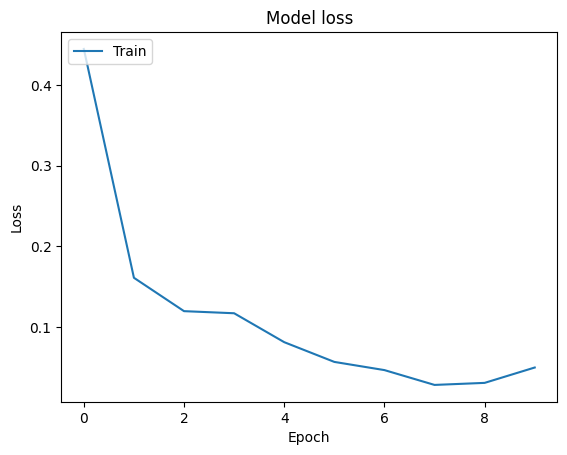

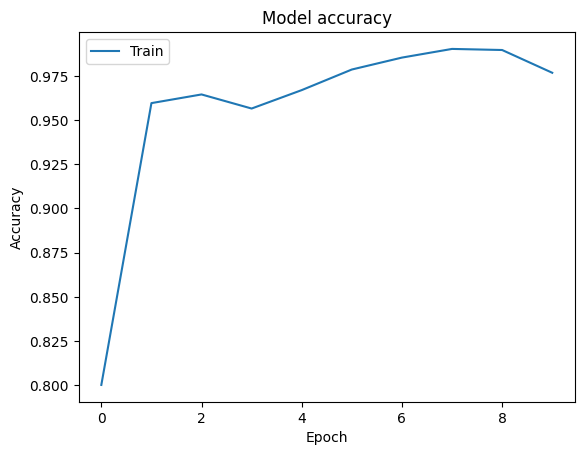

In [58]:
#Loss
plt.plot(history.history['loss']) 
#plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()
#Accuracy

plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### 7.3 Validation

#### 7.3.1 Apply Preprocessing To Test

In [59]:
miscropped_images_test, X_test_cropped = apply_haar_cascade_on_images(X_test, face_cascade)

print("All Test Cropped Images Shape:", X_test_cropped.shape)
print("All MisCropped Test Images:", miscropped_images_test)

All Test Cropped Images Shape: (408, 128, 128, 3)
All MisCropped Test Images: 38


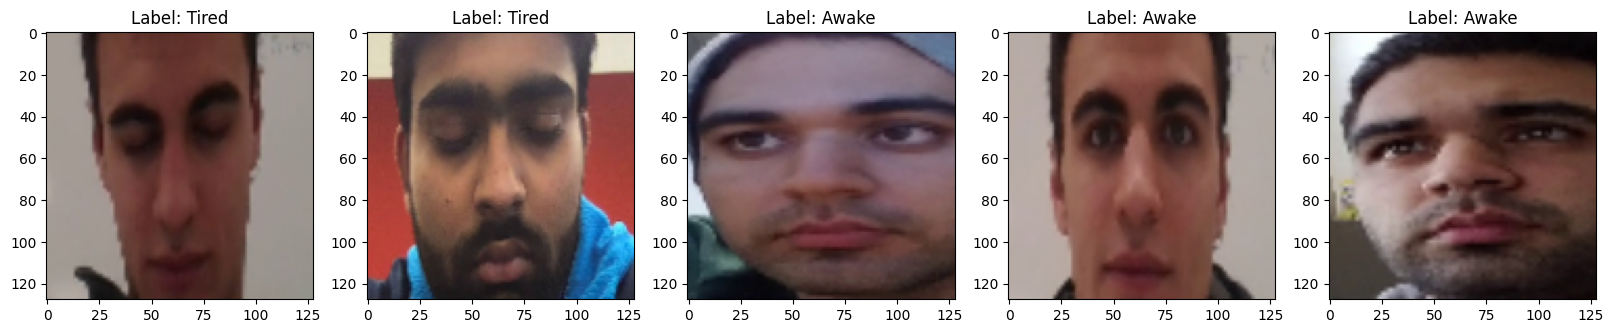

In [60]:
plot_line_of_images(X_test_cropped, y_test, 5)

In [61]:
X_test_normalized = X_test_cropped/255

#### 7.3.2 Apply Validation

In [62]:
y_pred = ModeloFinalCNN2.predict(X_test_normalized)

print(np.concatenate((np.round(y_pred.reshape(len(y_pred), 1)), y_test.reshape(len(y_test), 1)), axis=1))

13/13 [==============================] - 2s 103ms/step
[['1.0' 'Tired']
 ['1.0' 'Tired']
 ['0.0' 'Awake']
 ['0.0' 'Awake']
 ['0.0' 'Awake']
 ['0.0' 'Awake']
 ['0.0' 'Awake']
 ['0.0' 'Awake']
 ['1.0' 'Tired']
 ['0.0' 'Awake']
 ['0.0' 'Awake']
 ['0.0' 'Awake']
 ['0.0' 'Awake']
 ['1.0' 'Tired']
 ['1.0' 'Tired']
 ['0.0' 'Awake']
 ['0.0' 'Awake']
 ['1.0' 'Tired']
 ['0.0' 'Awake']
 ['1.0' 'Tired']
 ['0.0' 'Awake']
 ['0.0' 'Awake']
 ['0.0' 'Awake']
 ['0.0' 'Awake']
 ['0.0' 'Tired']
 ['0.0' 'Awake']
 ['0.0' 'Awake']
 ['1.0' 'Tired']
 ['1.0' 'Tired']
 ['0.0' 'Awake']
 ['0.0' 'Awake']
 ['1.0' 'Tired']
 ['1.0' 'Tired']
 ['0.0' 'Awake']
 ['1.0' 'Tired']
 ['0.0' 'Awake']
 ['1.0' 'Tired']
 ['0.0' 'Awake']
 ['0.0' 'Awake']
 ['1.0' 'Tired']
 ['1.0' 'Tired']
 ['0.0' 'Awake']
 ['1.0' 'Tired']
 ['1.0' 'Tired']
 ['0.0' 'Awake']
 ['1.0' 'Tired']
 ['0.0' 'Awake']
 ['0.0' 'Awake']
 ['1.0' 'Tired']
 ['0.0' 'Awake']
 ['0.0' 'Awake']
 ['1.0' 'Tired']
 ['0.0' 'Awake']
 ['0.0' 'Awake']
 ['0.0' 'Awake']
 ['1.0' 'T

In [64]:
threshold = 0.5  # ajusta el umbral según tus necesidades
y_pred_binary = np.where(y_pred > threshold, 1, 0)

y_test_numerical = np.array([class_mapping[label] for label in y_test])

cm = confusion_matrix(y_test_numerical, y_pred_binary)
print(cm)
accuracy = accuracy_score(y_test_numerical, y_pred_binary)
print("Accuracy:", accuracy)

[[223   3]
 [  5 177]]
Accuracy: 0.9803921568627451
